## Perform standard imports

In [ ]:
! pip install split-folders

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import splitfolders
import numpy as np
import copy
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')


In [ ]:
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))

GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd/content/drive/MyDrive/Course Material/Supervised Machine Learning/CNN_TF

/content/drive/MyDrive/CNN_TF


## Prepare train and test sets, loaders

In [ ]:
splitfolders.ratio("dataset", output="circle_square",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False) # default values

Copying files: 1000 files [00:21, 46.93 files/s]


In [ ]:
train_datagen = ImageDataGenerator(rotation_range=90,
                                     brightness_range=[0.1, 0.7],
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     validation_split=0.2,
                                     rescale = 1./255)


test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
batch_size = 32

training_set = train_datagen.flow_from_directory('circle_square/train/',
                                                 target_size = (200,200),
                                                 class_mode='binary',
                                                 shuffle = True,
                                                 batch_size = batch_size)
test_set = train_datagen.flow_from_directory('circle_square/val/',
                                                 target_size = (200,200),
                                                 class_mode='binary',
                                                 shuffle = False,
                                                 batch_size = 1)


Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


##  Import ResNet-50

In [ ]:
base_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top = False)
# setting include_top to False means the classification layers are not added and it is only a feature extracter and we will add
# the clasification layers by ourself.
output = base_model.output

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                       

# Freeze upto 143 layers

In [ ]:
for layer in base_model.layers[:143]: layer.trainable = False

In [ ]:
for i, layer in enumerate(base_model.layers):
  print(i, layer.name,"-", layer.trainable)

0 input_1 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block3_2_relu - False
35 conv2_block3_3_conv - 

# Adding more layers to base model

In [ ]:
model = Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D()) # For Flattening
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Training and Testing the model

In [ ]:
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001, momentum = 0.9) ,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(training_set, epochs = 20,  validation_data = test_set)

Epoch 1/20
25/25 [==============================] - 34s 832ms/step - loss: 0.8735 - accuracy: 0.5337 - val_loss: 0.7660 - val_accuracy: 0.5000
Epoch 2/20
25/25 [==============================] - 26s 1s/step - loss: 0.7194 - accuracy: 0.5587 - val_loss: 0.7163 - val_accuracy: 0.5000
Epoch 3/20
25/25 [==============================] - 27s 1s/step - loss: 0.7030 - accuracy: 0.5763 - val_loss: 0.7119 - val_accuracy: 0.5000
Epoch 4/20
25/25 [==============================] - 20s 800ms/step - loss: 0.6972 - accuracy: 0.5775 - val_loss: 0.7123 - val_accuracy: 0.5000
Epoch 5/20
25/25 [==============================] - 22s 863ms/step - loss: 0.6959 - accuracy: 0.5800 - val_loss: 0.6906 - val_accuracy: 0.5200
Epoch 6/20
25/25 [==============================] - 20s 795ms/step - loss: 0.6904 - accuracy: 0.6012 - val_loss: 0.7237 - val_accuracy: 0.5000
Epoch 7/20
25/25 [==============================] - 21s 855ms/step - loss: 0.6786 - accuracy: 0.5975 - val_loss: 0.6958 - val_accuracy: 0.5000
Epoch

In [ ]:
trainAcc = [100 * x for x in history.history['accuracy']]
testAcc = [100 * x for x in history.history['val_accuracy']]

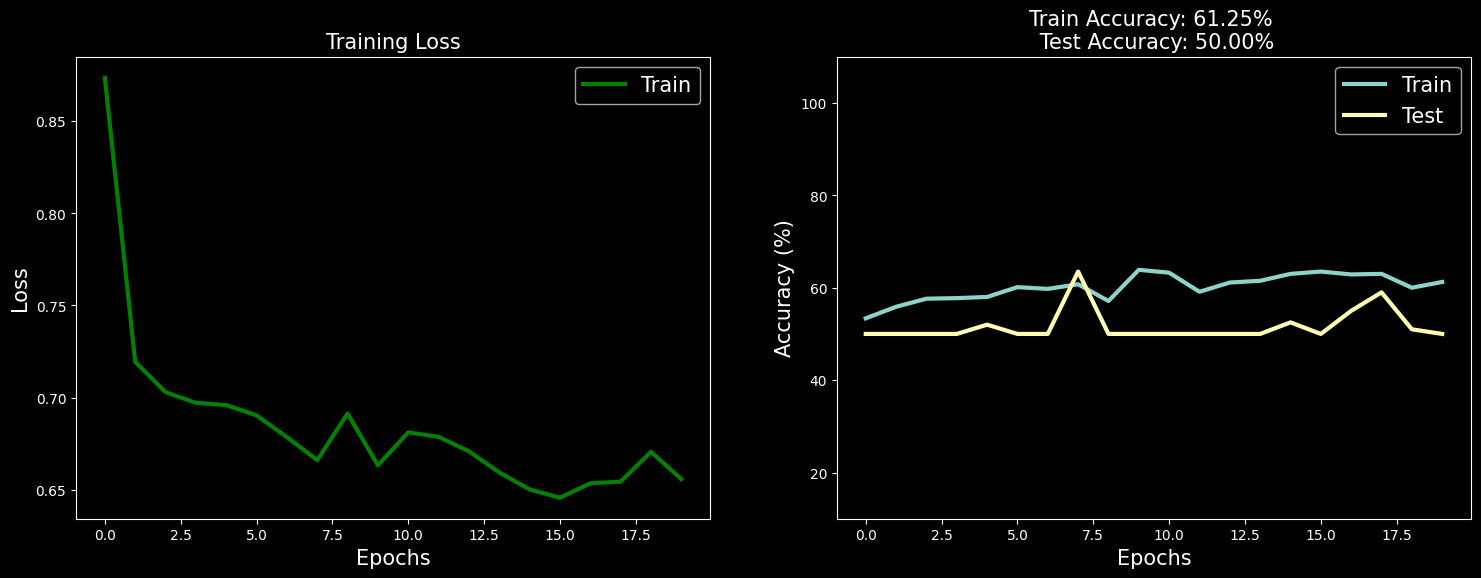

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(history.history['loss'], 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)


ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import splitfolders
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

## Prepare train and test sets, loaders

In [ ]:
splitfolders.ratio("dataset", output="Train_Test",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False) # default values

# Creating train and test data generators

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
num_classes = 2
img_shape = (200,200,3)
batch_size = 32

## Creating Training and Testing Datasets


In [ ]:
training_set = train_datagen.flow_from_directory('Train_Test/train',
                                                 target_size = (200,200),
                                                 class_mode='binary',
                                                 shuffle = True,
                                                 batch_size = batch_size)


In [ ]:
test_set = train_datagen.flow_from_directory('Train_Test/val',
                                                 target_size = (200,200),
                                                 class_mode='binary',
                                                 shuffle = False,
                                                 batch_size = batch_size)


##  Create CNN

In [ ]:
model = Sequential()
model.add(Conv2D(10 ,kernel_size = (5, 5), padding = 'SAME', input_shape = img_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides = 2))

model.add(Conv2D(20, (5, 5), padding='SAME')) # "SAME" tries to pad evenly left and right
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides = 2))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))



In [ ]:
model.summary()

# Setting Early Stopping Criterion

In [ ]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor = 'val_loss',
                             min_delta = 0,
                             patience = 3,
                             verbose =1,
                             restore_best_weights = True)


# Training and Testing the model

In [ ]:
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9) ,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
hist = model.fit(training_set,
                              epochs = 500,
                              validation_data = test_set,
                              callbacks = earlystop)

In [ ]:
trainAcc = [100 * x for x in hist.history['accuracy']]
testAcc = [100 * x for x in hist.history['val_accuracy']]

# Visualize the Model Performance

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(hist.history['loss'], 'g', lw = 3, label = 'Training Loss')
ax[0].plot(hist.history['val_loss'], 'y', lw = 3, label = 'Validation Loss')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)


ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()